In [1]:
from numpy.random import rand
import numpy as np, scipy
from scipy.stats import expon 
import matplotlib.pyplot as plt
from scipy.stats import poisson
import itertools
import pandas as pd
import seaborn as sns

## Exercise 2

#### Set equations and parameters

In [3]:
stoichiometry = [1, -1]
k0 = 0.2
k1 = 0.01

# The function takes the current state m and returns a vector with the propensities
def propensities(mRNA):
    return [k0, k1*mRNA]
def reaction_times(mRNA):
    a = propensities(mRNA)
    aInv = [1/s if s > 0 else np.inf for s in a] # Make sure the inverse of a is not 0
    return -np.log(rand(len(a))) * aInv

#### Simulation algorithm

In [5]:
def ssa_step(mRNA, tIn, tOut):
    #internal time
    t = tIn
    
    while t < tOut:
        rt = reaction_times(mRNA)
        # first reaction time
        tau = np.min(rt)
        # first reaction index
        idx = np.argmin(rt)
        
        # execute reaction
        if t + tau > tOut:
            t = tOut
        else:
            t += tau
            mRNA += stoichiometry[idx]
    return mRNA

Time after transient time : 460.5170185988091


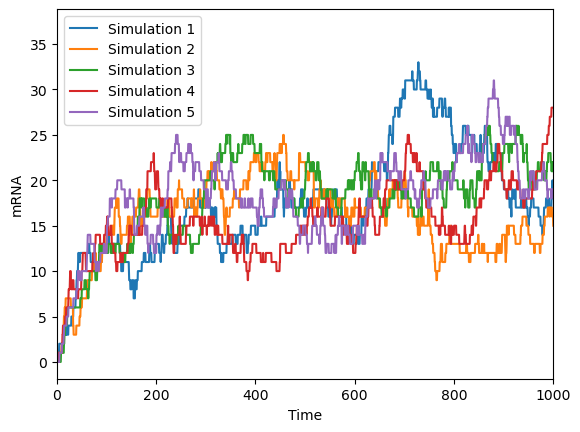

In [7]:
dt = 0.5

all_mRNA = []
all_time = []
all_transient_mRNA = []

num_simulations = 5
sim_time = 5000

# By solving with ODE's, we deduce the equation for when it reaches a steady state. 
# Here, we will calculate the time to reach 99% steady state as the 100% as it would only theoretically reach it at time = ∞
time_to_steady_state = -np.log(1 - 0.99) / k1
print("Time after transient time :", time_to_steady_state)

for sim in range(num_simulations):
    mRNA = [0]
    time = [0]
    transient_mRNA = [0]
    
    while time[-1] < sim_time:
        m = ssa_step(mRNA[-1], time[-1], time[-1] + dt)
        mRNA.append(m)
        time.append(time[-1] + dt)

        # We introduce the transient time obtained before.
        if time[-1] >= time_to_steady_state:
            transient_mRNA.append(m)

    all_mRNA.append(mRNA)
    all_time.append(time)
    all_transient_mRNA.append(transient_mRNA)

for sim in range(num_simulations):
    plt.plot(all_time[sim], all_mRNA[sim], label=f"Simulation {sim+1}")

plt.xlabel("Time")
plt.ylabel("mRNA")
# plt.title("Independent Simulations of mRNA Dynamics")
plt.xlim(0, 1000)
plt.legend()
plt.show()

## Exercise 3

In [9]:
mean = np.mean(all_transient_mRNA)
var = np.var(all_transient_mRNA)
fano = var / mean

print("Mean:", round(mean, 2))
print("Variance:", round(var, 2))
print("Fano factor:", round(fano, 2))

Mean: 20.06
Variance: 21.64
Fano factor: 1.08


In [ ]:
## Mean value approaches to the state of mRNA at steady state. 
## A Fano factor less than one indicates sub-Poisson variability, 
# a condition referred to as “under-dispersion” ; a Fano factor greater than one, on the other hand, 
# indicates greater-than-Poisson variability, commonly known as “over-dispersion”.

# By solving the chemical master equation we can discuss the Poisson distribution.


# We can calculate the noise with the Fano factor or the CV. 

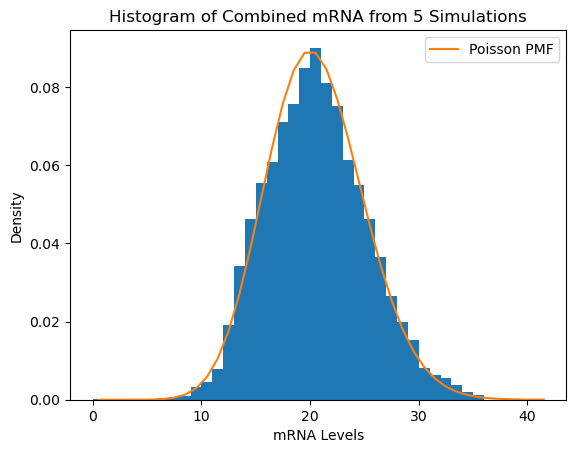

In [11]:
mu = k0 / k1

combined_mRNA = list(itertools.chain(*all_transient_mRNA)) ## Change for concatenate?

plt.hist(combined_mRNA, bins=range(0, max(combined_mRNA)), density=True)
arange = np.arange(0, max(combined_mRNA)+5)
plt.plot(arange + 0.5, poisson.pmf(arange, mu), label="Poisson PMF")
# Add labels and title
plt.xlabel("mRNA Levels")
plt.ylabel("Density")
plt.title("Histogram of Combined mRNA from 5 Simulations")
plt.legend()
plt.show()

## Exercise 4

In [13]:
### Functions for the Gillespie algorithm accounting for protein dynamics

stoichiometry = np.array([[1, 0], [-1, 0], [0, 1],[0, -1]]) 

def propensities_2(state):
    mRNA, protein = state
    return [
        k0,          
        k1 * mRNA,   
        k2 * mRNA,   
        k3 * protein 
    ]
def reaction_times_2(state):
    a = propensities_2(state)
    aInv = [1/s if s > 0 else np.inf for s in a] # Make sure the inverse of a is not 0
    return -np.log(rand(len(a))) * aInv

def ssa_step_2(state, tIn, tOut):
    t = tIn
    while t < tOut:
        rt = reaction_times_2(state)
        tau = np.min(rt)
        idx = np.argmin(rt)
        
        if t + tau > tOut:
            t = tOut
        else:
            t += tau
            state += stoichiometry[idx]
    return state

In [15]:
# Simulation parameters
dt = 0.5  
num_simulations = 5
sim_time = 5000

k0 = 0.2
k1 = 0.01
k2 = 5.0
k3 = 1

# Calculate time to reach 99% steady state

time_to_steady_state_mRNA = -np.log(1 - 0.99) / k1
time_to_steady_state_protein = np.log(1 / (1 - 0.99)) / k3
print("Time after transient time for mRNA:", time_to_steady_state_mRNA)
print("Time after transient time for proteins:", time_to_steady_state_protein)

### As it is larger, we will consider as transient time for the mRNA model only

Time after transient time for mRNA: 460.5170185988091
Time after transient time for proteins: 4.605170185988091


In [17]:
# Initialize state 
state = np.array([0, 0]) 
mRNA = [state[0]]        
protein = [state[1]]     
time = [0]               

all_mRNA = []
all_time = []
all_protein = []
all_transient_protein = []

# Simulation loop
for sim in range(num_simulations):
    state = np.array([0, 0])  
    mRNA = [0]
    protein = [0] 
    transient_protein = [0]
    time = [0]
    
    while time[-1] < sim_time:
        state = ssa_step_2(state, time[-1], time[-1] + dt)  
        mRNA.append(state[0])                           
        protein.append(state[1])                       
        time.append(time[-1] + dt)   

    # We assume transient time after 460 seconds.
        if time[-1] >= time_to_steady_state_mRNA:
            transient_protein.append(state[1])
    
    all_mRNA.append(mRNA)
    all_protein.append(protein)
    all_time.append(time)
    
    all_transient_protein.append(transient_protein)

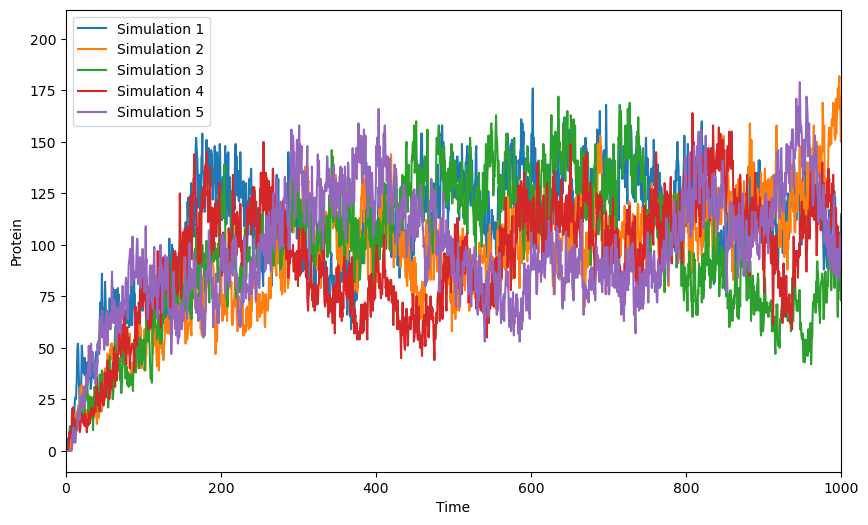

In [47]:
# Plot protein
plt.figure(figsize=(10, 6))

for sim in range(num_simulations):
    plt.plot(all_time[sim], all_protein[sim], label=f"Simulation {sim+1}")

plt.xlabel("Time")
plt.ylabel("Protein")
# plt.title("Independent Simulations of mRNA Dynamics")
plt.xlim(0, 1000)
plt.legend()
plt.show()

In [55]:
mean_p = np.mean(all_transient_protein)
var_p = np.var(all_transient_protein)
fano_p = var_p / mean_p

print("Mean:", round(mean_p, 2))
print("Variance:", round(var_p, 2))
print("Fano factor:", round(fano_p, 2))

Mean: 101.78
Variance: 620.48
Fano factor: 6.1


In [155]:
# Assuming you already have the transient data from all_simulations
# Example simulation results (replace this with your actual data)
mean_simulations = []
var_simulations = []
fano_simulations = []

# Calculate statistics for each simulation
for sim in range(num_simulations):
    # For each simulation, calculate the mean, variance, and fano factor
    mean_p = np.mean(all_transient_protein[sim])
    var_p = np.var(all_transient_protein[sim])
    fano_p = var_p / mean_p
    
    # Round values and append to the lists
    mean_simulations.append(round(mean_p, 2))
    var_simulations.append(round(var_p, 2))
    fano_simulations.append(round(fano_p, 2))

# Calculate the mean of the means, variances, and Fano factors (instead of sum)
mean_of_means = round(np.mean(mean_simulations), 2)
mean_of_variances = round(np.mean(var_simulations), 2)
mean_of_fanos = round(np.mean(fano_simulations), 2)

# Create a DataFrame to store the results, including the mean row
data = {
    'Simulation': [f'Simulation {i+1}' for i in range(num_simulations)] + ['Mean'],
    'Mean': mean_simulations + [mean_of_means],
    'Variance': var_simulations + [mean_of_variances],
    'Fano factor': fano_simulations + [mean_of_fanos],
}

# Create a pandas dataframe with your data
df = pd.DataFrame(data)

# Drop the default index column
df = df.reset_index(drop=True)

# Display the DataFrame
df


IndexError: list index out of range

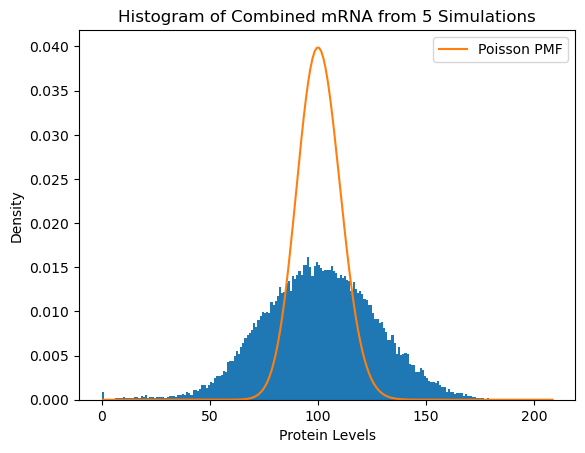

In [127]:
mu = (k0 * k2) / (k1 * k3)

combined_protein = list(itertools.chain(*all_protein))

plt.hist(combined_protein, bins=range(0, max(combined_protein)), density=True)
arange = np.arange(0, max(combined_protein)+5)
plt.plot(arange + 0.5, poisson.pmf(arange, mu), label="Poisson PMF")
# Add labels and title
plt.xlabel("Protein Levels")
plt.ylabel("Density")
plt.title("Histogram of Combined mRNA from 5 Simulations")
plt.legend()
plt.show()

## Exercise 5

In [ ]:
# Now, for this last question, we are asked to change the transcription rate to random parameters

# Literature search in regards to genome-wide studies of molecular noise.
# When fano is high, means that the expression spikes, this could be useful for induced genes.
# When fano is low, the expression mantains a more stable behaviour, useful for genes that constitutely expresses such as housekeeping genes.

In [215]:
stoichiometry = np.array([[1, 0], [-1, 0], [0, 1],[0, -1]]) 

# Initialize state 
state = np.array([0, 0]) 
mRNA = [state[0]]        
protein = [state[1]]     
time = [0]  

def propensities_3(state):
    mRNA, protein = state
    return [
        k0_values[sim],         
        k1 * mRNA,   
        k2 * mRNA,   
        k3 * protein 
    ]
def reaction_times_3(state):
    a = propensities_3(state)
    aInv = [1/s if s > 0 else np.inf for s in a] # Make sure the inverse of a is not 0
    return -np.log(rand(len(a))) * aInv

def ssa_step_3(state, tIn, tOut):
    t = tIn
    while t < tOut:
        rt = reaction_times_3(state)
        tau = np.min(rt)
        idx = np.argmin(rt)
        
        if t + tau > tOut:
            t = tOut
        else:
            t += tau
            state += stoichiometry[idx]
    return state

In [217]:
# Fixed parameters

k1 = 0.01
k2 = 5.0
k3 = 1.0

# Simulation parameters
dt = 0.5
sim_time = 1000
num_simulations = 3000

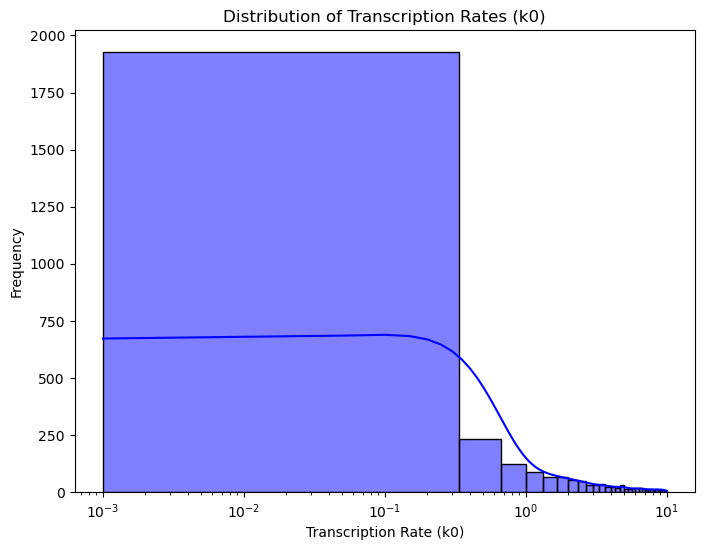

In [219]:
# Establish steady state of mRNA. Even if k0 changes, it only depends on k1 so it remains constant
time_to_steady_state_mRNA = -np.log(1 - 0.99) / k1

# Randomise k0 from a logarithmic uniform distribution

min_val = 1e-3
max_val = 10
k0_values = []

for sim in range(num_simulations):
    log_min = np.log10(min_val)
    log_max = np.log10(max_val)
    log_k0 = np.random.uniform(log_min, log_max)  # Sample in log space
    k0 = 10**log_k0  # Convert back to linear space
    k0_values.append(k0)

# Plot the distribution of Transcription Rates (k0)
plt.figure(figsize=(8, 6))
sns.histplot(k0_values, kde=True, color='blue', bins=30)
plt.xscale('log')
plt.title('Distribution of Transcription Rates (k0)')
plt.xlabel('Transcription Rate (k0)')
plt.ylabel('Frequency')
plt.show()

In [221]:
# Initialize lists to store results

mean_mRNA = []
var_mRNA = []
std_mRNA = []
mean_protein = []
var_protein = []
std_protein = []

# Initialize the result storage for all simulations
all_mRNA = []
all_protein = []
all_time = []

# Simulation loop
for sim in range(num_simulations):
    state = np.array([0, 0])  
    mRNA = [0]
    protein = [0]  
    time = [0]

    transient_mRNA = [0]
    transient_protein = [0]

    while time[-1] < sim_time:
        state = ssa_step_3(state, time[-1], time[-1] + dt)  
        mRNA.append(state[0])                           
        protein.append(state[1])                       
        time.append(time[-1] + dt)

        # Collect specific data after transient time
        if time[-1] >= time_to_steady_state_mRNA:
            transient_mRNA.append(state[0])
            transient_protein.append(state[1])
    
    # Store data for each simulation
    all_mRNA.append(mRNA)
    all_protein.append(protein)
    all_time.append(time)

    # Store data for each simulation and calculate stats only after transient time
    if len(transient_mRNA) > 0:
        mean_mRNA.append(np.mean(transient_mRNA))
        var_mRNA.append(np.var(transient_mRNA)) 
        std_mRNA.append(np.std(transient_mRNA))

        mean_protein.append(np.mean(transient_protein))
        var_protein.append(np.var(transient_protein)) 
        std_protein.append(np.std(transient_protein))

KeyboardInterrupt: 

In [205]:
all_mean_mRNA = np.mean(mean_mRNA)
all_var_mRNA = np.mean(var_mRNA)
all_std_mRNA = np.mean(std_mRNA)

all_mean_protein = np.mean(mean_protein)
all_var_protein = np.mean(var_protein)
all_std_protein = np.mean(std_protein)

print("mRNA Mean:", round(all_mean_mRNA, 2))
print("mRNA Variance:", round(all_var_mRNA, 2))
print("mRNA Coefficient of Variation:", round(all_std_mRNA, 2))

print("Protein Mean:", round(all_mean_protein, 2))
print("Protein Variance:", round(all_var_protein, 2))
print("Protein Coefficient of Variation:", round(all_std_protein, 2))

mRNA Mean: 181.88
mRNA Variance: 1372.91
mRNA Coefficient of Variation: 20.89
Protein Mean: 907.94
Protein Variance: 35083.1
Protein Coefficient of Variation: 107.3


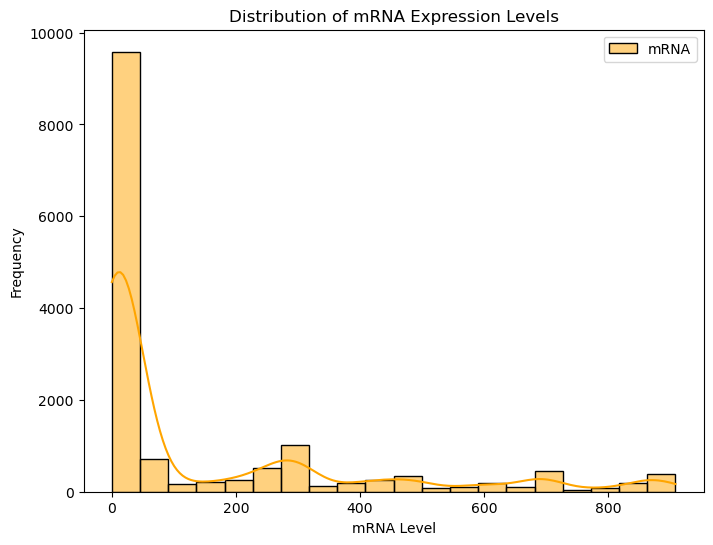

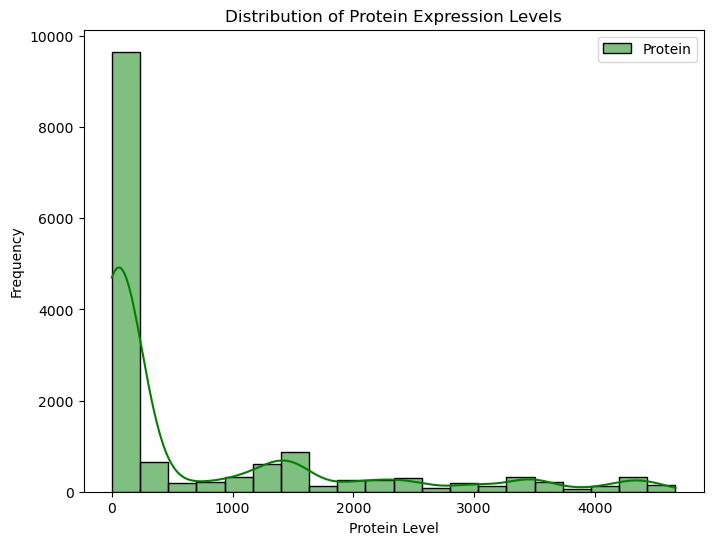

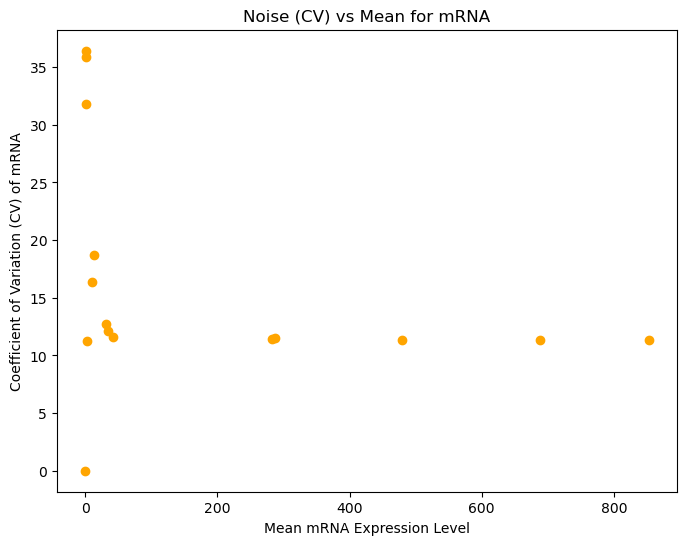

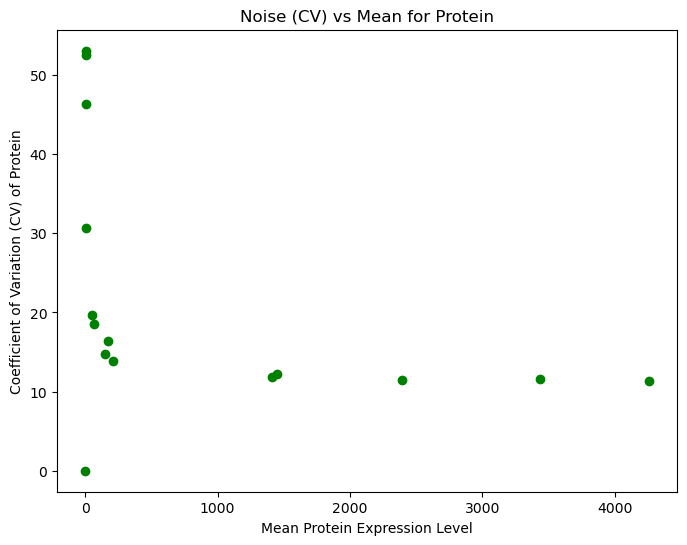

In [207]:
# Distribution of mRNA Expression Levels
plt.figure(figsize=(8, 6))
sns.histplot(np.concatenate(all_mRNA), kde=True, color='orange', label='mRNA', bins=20)
plt.title('Distribution of mRNA Expression Levels')
plt.xlabel('mRNA Level')
plt.ylabel('Frequency')
plt.legend()
plt.show()  # Ensure the plot is displayed

# Distribution of Protein Expression Levels
plt.figure(figsize=(8, 6))
sns.histplot(np.concatenate(all_protein), kde=True, color='green', label='Protein', bins=20)
plt.title('Distribution of Protein Expression Levels')
plt.xlabel('Protein Level')
plt.ylabel('Frequency')
plt.legend()
plt.show()  # Ensure the plot is displayed

# Scatter Plot of Noise (CV) vs Mean for mRNA
cv_mRNA = [std / mean * 100 if mean != 0 else 0 for std, mean in zip(std_mRNA, mean_mRNA)]
plt.figure(figsize=(8, 6))
plt.scatter(mean_mRNA, cv_mRNA, color='orange')
plt.title('Noise (CV) vs Mean for mRNA')
plt.xlabel('Mean mRNA Expression Level')
plt.ylabel('Coefficient of Variation (CV) of mRNA')
plt.show()  # Ensure the plot is displayed

# Scatter Plot of Noise (CV) vs Mean for Protein
cv_protein = [std / mean * 100 if mean != 0 else 0 for std, mean in zip(std_protein, mean_protein)]
plt.figure(figsize=(8, 6))
plt.scatter(mean_protein, cv_protein, color='green')
plt.title('Noise (CV) vs Mean for Protein')
plt.xlabel('Mean Protein Expression Level')
plt.ylabel('Coefficient of Variation (CV) of Protein')
plt.show()  # Ensure the plot is displayed